In [1]:
import os
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unrar x "/content/drive/MyDrive/Copy of Project Data.rar" "/content/dataset/"

In [4]:
train_dataset_path = '/content/dataset/For Project/Classification/Training/'
test_dataset_path = '/content/dataset/For Project/Classification/Validation/'

In [5]:
train_transforms = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.RandomHorizontalFlip(30),
    transforms.RandomRotation(10),
    transforms.ToTensor()

])
test_transforms = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor()
])

In [6]:
train_dataset = torchvision.datasets.ImageFolder(root=train_dataset_path,transform = train_transforms)
test_dataset = torchvision.datasets.ImageFolder(root=test_dataset_path,transform = test_transforms)

In [10]:
def show_transformed_images(dataset):
    loader = torch.utils.data.DataLoader(dataset,batch_size=6,shuffle=True)
    batch = next(iter(loader))
    images,labels = batch
    
    grid = torchvision.utils.make_grid(images,nrow = 3)
    plt.figure(figsize=(11,11))
    plt.imshow(np.transpose(grid,(1,2,0)))
    print('labels:',labels)
    

labels: tensor([1, 0, 2, 3, 1, 2])


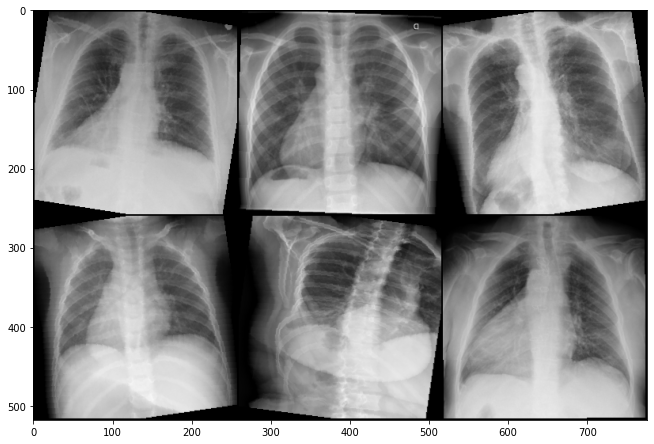

In [13]:
show_transformed_images(train_dataset)

labels: tensor([1, 2, 1, 0, 1, 1])


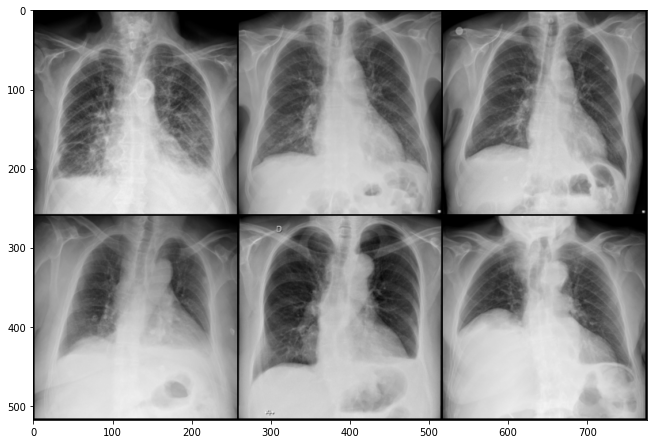

In [12]:
show_transformed_images(test_dataset)

In [14]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 32, shuffle=True)

In [15]:
def set_device():
  if torch.cuda.is_available():
    dev = "cuda:0"
  else:
    dev = "cpu"
  return torch.device(dev)

In [16]:
def train_nn(model, train_loader, test_loader, criterion, optimizer, n_epochs):
  device = set_device()

  for epoch in range(n_epochs):
    print("Epoch number %d " % (epoch+1))
    model.train()
    running_loss = 0.0
    running_correct = 0.0
    total = 0
    for data in train_loader:
      images, labels = data
      images = images.to(device)
      labels = labels.to(device)
      total += labels.size(0)

      optimizer.zero_grad()
      outputs = model(images)
      _, predicted = torch.max(outputs.data,1)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      
      running_loss += loss.item()
      running_correct += (labels==predicted).sum().item()

    
    epoch_loss = running_loss/len(train_loader)
    epoch_acc = 100.00 * running_correct/total
    print( "        - Training dataset. Got %d out of %d images correctly (%.3f%%). Epoch Loss: %.3f"
                    % (running_correct, total, epoch_acc, epoch_loss))
    

    evaluate_model_on_test_set(model, test_loader)

  print("Finished")
  return model

In [17]:
def evaluate_model_on_test_set(model, test_loader):
  model.eval()
  predicted_correctly_on_epoch = 0
  total = 0
  device = set_device()

  with torch.no_grad():
    for data in test_loader:
      images, labels = data
      images = images.to(device)
      labels = labels.to(device)
      total += labels.size(0)

      outputs = model(images)
      _, predicted = torch.max(outputs.data,1)

      predicted_correctly_on_epoch += (predicted == labels).sum().item()

    
  
  epoch_acc = 100.00 * predicted_correctly_on_epoch / total
  print("      - Testing dataset. Got %d out of %d images correctly (%.3f%%"
                % (predicted_correctly_on_epoch, total ,epoch_acc))






In [18]:
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

resnet18_model = models.resnet18(pretrained=True)
num_ftrs = resnet18_model.fc.in_features
number_of_classes = 6
resnet18_model.fc = nn.Linear(num_ftrs, number_of_classes)
device = set_device()
resnet18_model = resnet18_model.to(device)
loss_fn = nn.CrossEntropyLoss()

optimizer = optim.SGD(resnet18_model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.003)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
train_nn(resnet18_model, train_loader, test_loader, loss_fn, optimizer, 20)

Epoch number 1 
